<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 2

In this session, we will focus on how to uncover long timescale properties of complex dynamical systems through a transfer operator approach.

Before we start, load the following python packages:

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

In [2]:
import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

/content/DPG_PhysicsBehavior_2026
Already up to date.
/content
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [3]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

## Stochastic dynamics on a 1d double well

In notebook_1, we directly used the analytical expression to solve the Fokker-Planck equation using a finite-difference approach. However, in most real world scenarios, the equations of motion are unavailable, and instead we only have access to a finite set of observations. Here, we will see how we can directly approximate the transfer operator and its eigenspectrum directly from observations.

Let's consider again overdamped Langevin dynamics on a potential landscape,

$$
\dot{x}(t) = -\partial_x V(x) + \sqrt{2 T_x}\,\eta(t),
\qquad \langle \eta(t)\eta(t') \rangle = \delta(t-t').
$$

Where the potential landscape is given by of a double well type:

$$
V(x) = \frac{x^4}{4} -\mu \frac{x^2}{2}
$$


In [4]:
from numba import jit,prange
@jit(nopython=True, parallel=True)
def simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling):
    n_sims = len(x0s)
    sims = np.zeros((n_sims, int(max_iters/downsampling)))
    for ks in prange(n_sims):
        x0 = x0s[ks]
        x = x0
        for i in range(max_iters):
            new_x = x + (-x**3+mu*x) * dt + np.sqrt(2 * Tx) * np.random.normal(0, np.sqrt(dt))
            x = new_x
            if i%downsampling==0:
                sims[ks, int(i/downsampling)] = x
    return sims

In [5]:
Tx=3e-1 #temperature
T = 200
dt=1e-3
max_iters=int(T/dt)
final_dt = 1e-1
downsampling = int(final_dt/dt)
n_sims = 500
x0s = np.random.uniform(-1,1,n_sims)
mu=1
sims = simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling)

## Estimating the transition matrix from data

The finite time operator $P_\tau$ estimated is effectively a transition probability matrix among state space regions, which can be estimated directly from time series observations. The simplest way to do this is to simply partition the domain and count transitions among state space regions. This is called the Ulam-Galerkin method.

Technically speaking, the Galerkin projection takes the infinite dimensional operator onto an $N\times N$ operator of finite rank by truncating an infinite dimensional set of basis functions at a finite $N$. Ulam's method uses characteristic functions as the basis for this projection,

$$
\zeta_i(x) = \begin{cases}
    1, & \text{for $x \in s_i$}\\
    0, & \text{otherwise}
    \end{cases}.
$$

We thus partition the space into $N$ connected sets with nonempty and disjoint interior that covers $M$: $M = \cup_{i=1}^N s_i$, and approximate the transfer operator as a Markov chain by counting transitions from $s_i$ to $s_j$ in a finite time $\tau$. Given T observations, a set of $N$ partitions, and a transition time $\tau$, we compute

$$
C_{ij}(\tau) = \sum_{t=0}^{T-\tau}\zeta_i(x(t))\zeta_j(x(t+\tau))
$$

The maximum likelihood estimator of the transition matrix is obtained by simply row normalizing the count matrix,

$$
P_{ij}(\tau) = \frac{C_{ij}(\tau)}{\sum_j C_{ij}(\tau)}.
$$

Let's see how that works for our simulations. To partition the state-space into Voronoi cells, we will use the k-means algorithm to identify $N$ clusters that minimize the within cluster variances


In [6]:
N=1000
#labels_all is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
labels_all,centers = cl.kmeans_partition(np.hstack(sims).reshape(-1,1),N,batchsize=10000,return_centers=True)

In [7]:
delay_range = np.unique(np.array(np.logspace(0,2.5,20),dtype=int))
n_modes=5
eigvals_delay = np.zeros((len(delay_range),n_modes))
tscales_delay = np.zeros((len(delay_range),n_modes))
for kd,delay in enumerate(delay_range):
  P_emp = op_calc.transition_matrix(labels_all,delay)
  eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(P_emp,k=n_modes+1)
  timps=-delay*final_dt/np.log(eigvals_emp[1:].real)
  tscales_delay[kd] = timps
  eigvals_delay[kd] = eigvals_emp[1:].real
  print(delay)

1
2
3
4
6
8
11
15
20
28
37
51
69
94
127
172
233
316


In [8]:
def state_lifetime(states,tau):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries))*tau)
    return durations


discrete_state_traj = ma.zeros(np.hstack(sims).shape,dtype=int)
discrete_state_traj[np.hstack(sims)>0]=1

durs_emp = np.hstack(state_lifetime(discrete_state_traj,final_dt))

In [9]:
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid

def potential(x,mu):
    return x**4 / 4 - mu * x**2 / 2

def exppot(x, Tx,mu,sign=-1, fun=lambda z: 1):
    return np.exp(sign*potential(x,mu)/Tx)*fun(x)

def omega_be(Tx,mu):
    z = np.linspace(-20, 0, 1000)
    iarr = cumulative_trapezoid(exppot(z,Tx,mu), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 1000)
    oarr = cumulative_trapezoid(exppot(y,Tx,mu, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)

    return 1/(2*ofun(0))


def transition_time_be(Tx,mu):
    z = np.linspace(-20, 0, 1000)
    iarr = cumulative_trapezoid(exppot(z,Tx,mu), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 1000)
    oarr = cumulative_trapezoid(exppot(y,Tx,mu, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)

    return ofun(0)

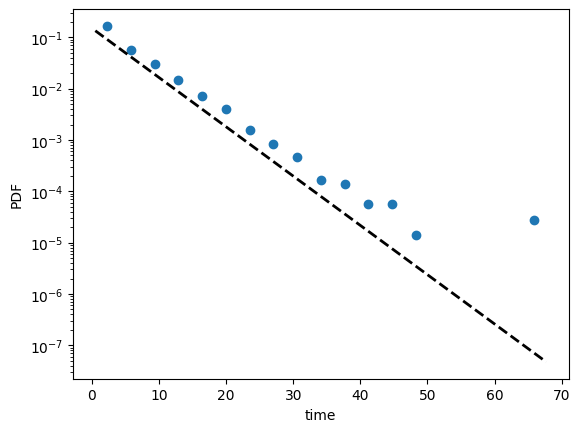

In [10]:
tmin=.5
tmax=np.max(durs_emp)
freqs,bin_edges = np.histogram(durs_emp, bins=np.linspace(tmin,tmax,20), density=True)
centers_ = (bin_edges[1:]+bin_edges[:-1])/2
# plt.hist(durs, bins=np.linspace(tmin,tmax,10), density=True)
plt.scatter(centers_,freqs,marker='o')
times = np.linspace(tmin,tmax,10)
plt.plot(times,1.5e-1*np.exp(-times/transition_time_be(Tx,mu)),c='k',lw=2,ls='--')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('time')
plt.show()

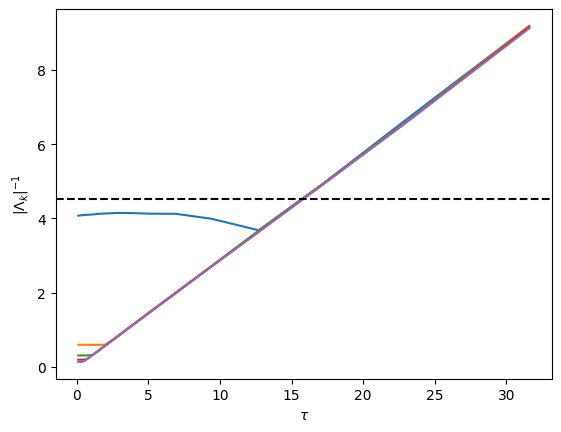

In [11]:
plt.plot(delay_range*final_dt,tscales_delay)
plt.axhline(transition_time_be(Tx,mu),c='k',ls='--')
plt.ylabel(r'$|\Lambda_k|^{-1}$')
plt.xlabel(r'$\tau$')
plt.show()

To emulate the calculation from notebook_1, we take a delay of 1 frame (0.1s) and estimate the transition matrix by counting. As we can see, the implied timescales, estimates as $|\Lambda|_k^{-1} = -\tau/\log(\lambda_k(\tau))$ match the transition time as obtained analytically above

In [12]:
delay=1
P_emp = op_calc.transition_matrix(labels_all,delay)
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(P_emp,k=5)
timp=-delay*final_dt/np.log(eigvals_emp[1].real)

print('estimated timescale: {:.4f}'.format(timp))

print('analytical timescale: {:.4f}'.format(transition_time_be(Tx,mu)))

estimated timescale: 4.0719
analytical timescale: 4.5231


We can now proceed as above, and find the location of the potential energy barrier by calculating the coherence of each set along $\phi_2$, which should resemble the eigenvector calculated above with the analytical operator (up to a sign flip)

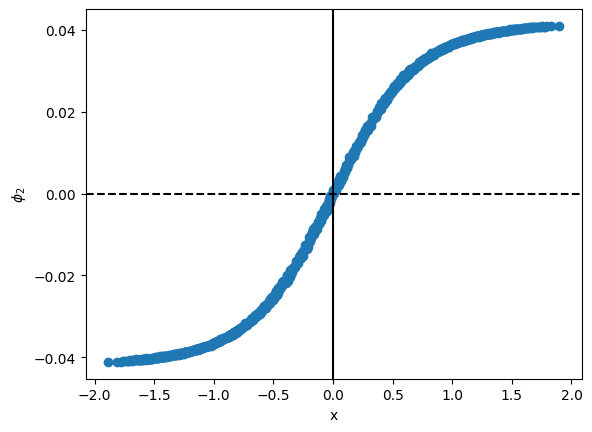

In [13]:
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)
phi2_emp = eigvecs_emp[:,1]
sorted_indices = np.argsort(phi2_emp)
plt.scatter(centers[sorted_indices],phi2_emp[sorted_indices])
plt.ylabel(r'$\phi_2$')
plt.xlabel('x')
plt.axvline(0,c='k')
plt.axhline(0,c='k',ls='--')
plt.show()


Then, we can proceed as in notebook_1, and find the location that separates the two metastable basins through the coherence measure.

In [14]:
inv_measure_emp = op_calc.stationary_distribution(P_emp)
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2_emp,inv_measure_emp,P_emp,return_rho=True)

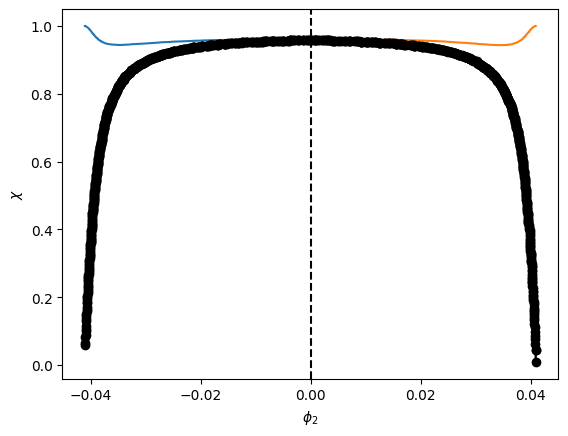

In [15]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2$')
plt.show()

We can also then build a coarse-grained Markov model that capture only the transitions among the metastable states on long timescales. Since we coarse-grain in space, we should also select a larger transition time

In [16]:
label_traj=km_labels[labels_all]

In [17]:
delay=5
Pc = op_calc.transition_matrix(label_traj,delay)

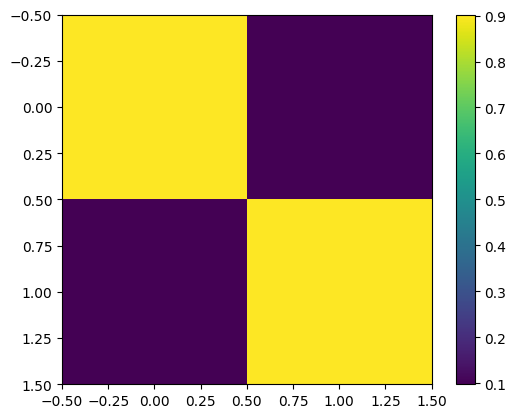

In [18]:
plt.imshow(Pc.todense())
plt.colorbar()
plt.show()

In [19]:
from joblib import Parallel, delayed

def simulate(P,state0,iters):
    '''
    Monte Carlo simulation of the markov chain characterized by the matrix P
    state0: initial system
    iters: number of iterations of the simulation
    '''
    states = np.zeros(iters,dtype=int)
    states[0]=state0
    state=state0
    for k in range(1,iters):
        new_state = np.random.choice(np.arange(P.shape[1]),p=list(P[state,:]))
        state=new_state
        states[k]=state
    return states

n_sims=500
state0s = np.random.choice([0,1],n_sims)
n_iters=2000

sims_coarse = Parallel(n_jobs=-1)(delayed(simulate)(Pc.toarray(),state0,n_iters) for state0 in state0s)



In [20]:
all_durs = np.hstack([np.hstack(state_lifetime(ma.array(sim),final_dt*delay)) for sim in sims_coarse])

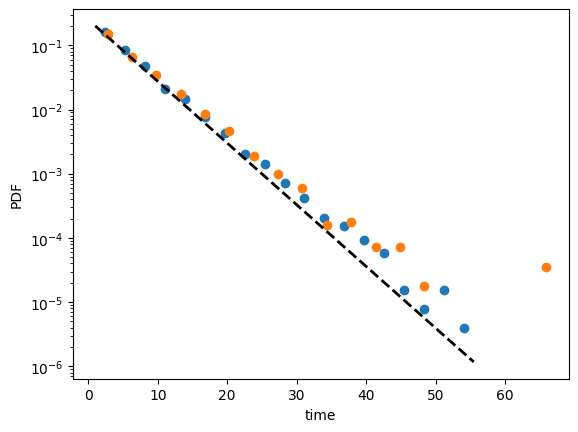

In [21]:
tmin=1
tmax=np.max(all_durs)
freqs,bin_edges = np.histogram(all_durs, bins=np.linspace(tmin,tmax,20), density=True)
centers_ = (bin_edges[1:]+bin_edges[:-1])/2
# plt.hist(durs, bins=np.linspace(tmin,tmax,10), density=True)
plt.scatter(centers_,freqs,marker='o')
times = np.linspace(tmin,tmax,10)
plt.plot(times,2.5e-1*np.exp(-times/transition_time_be(Tx,mu)),c='k',lw=2,ls='--')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('time')
tmin=1
tmax=np.percentile(durs_emp,100)
freqs,bin_edges = np.histogram(durs_emp, bins=np.linspace(tmin,tmax,20), density=True)
centers_ = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers_,freqs,marker='o')
# plt.xlim(0,50)
# plt.ylim(1e-4,3e-1)
plt.show()